In [7]:
%pylab inline
import pandas as pd
import seaborn as sns
import scipy
import skimage
# sns.set_style("ticks")
from pathlib import Path
output_path_images = Path("../text/")
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0, str(path_to_script))
import scaffan
import scaffan.texture
import scaffan.slide_segmentation
import io3d # just to get data
import scaffan.image as scim
import io3d

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Read the data

2020-04-01 21:31:11.982 | DEBUG    | io3d.cachefile:__init__:26 - cache filename: ~/.io3d_cache.yaml
2020-04-01 21:31:11.985 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_.
2020-04-01 21:31:11.987 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_medical
2020-04-01 21:31:11.989 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_medical/orig
2020-04-01 21:31:11.991 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_medical/orig/Scaffan-analysis
2020-04-01 21:31:11.993 | DEBUG    | io3d.datasets:join_path:304 - sample_data_pathC:\Users\Jirik\data
2020-04-01 21:31:11.994 | DEBUG    | io3d.datasets:join_path:305 - path C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi
2020-04-01 21:31:11.995 | DEBUG    | scaffan.image:__init__:203 - fs_enc: utf-8
2020-04-01 21:31:11.996 | DEBUG    | scaffan.image:__init__

[0.007271901, 0.007271901]
filename: C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi


2020-04-01 21:31:13.092 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:31:12.924\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'


[51]


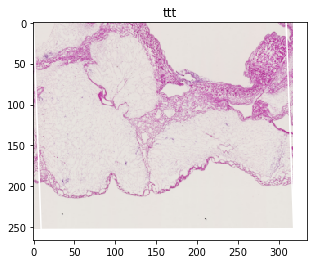

In [3]:
pixelsize_mm=[0.007271901] * 2
# pixelsize_mm=[0.00363595] * 2
# pixelsize_mm=[0.001817975] * 2
print(pixelsize_mm)

# fn = io3d.datasets.join_path("medical", "orig", "sample_data", "SCP003", "SCP003.ndpi", get_root=True)
fn = io3d.datasets.join_path("medical", "orig", "Scaffan-analysis", "PIG-003_J-18-0165_HE.ndpi", get_root=True)
title = "full segmentation"


ofn_filled = output_path_images / f"ground_true_annotation_{Path(fn).stem}_{title}_pixelsize_mm_{pixelsize_mm[0]}.png"
ofn_raster = output_path_images / f"raster_{Path(fn).stem}_{title}_pixelsize_mm_{pixelsize_mm[0]}.png"


print(f"filename: {fn}")
anim = scim.AnnotatedImage(fn)

# ann_ids = anim.select_annotations_by_color("#000000")
ann_ids = anim.select_annotations_by_title(title)
print(ann_ids)
view = anim.get_views(
    ann_ids, 
#     level=6, 
    margin=0, pixelsize_mm=pixelsize_mm)[0]

img = view.get_region_image(as_gray=False)
plt.imsave(ofn_raster, img)

plt.imshow(img, cmap='gray')
view.plot_annotations(ann_ids[0])

# Get manual segmentations

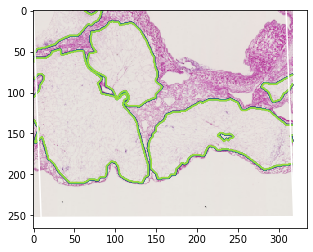

In [21]:

seg_black = view.get_annotation_raster_by_color("#000000")
seg_magenta = view.get_annotation_raster_by_color("#FF00FF")
seg_red = view.get_annotation_raster_by_color("#FF0000")

plt.imshow(img)
plt.contour(seg_black)
view.plot_annotations(ann_ids[0])


# Remove overlays

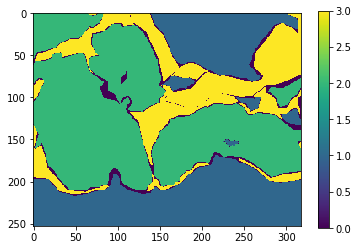

In [22]:
# see overlays
# plt.imshow(img)
overlays = (1*seg_black + 1*seg_magenta + 1* seg_red) > 1
segmentation = 2*seg_black + 1*seg_magenta + 3* seg_red
segmentation[overlays] = 0
plt.imshow(segmentation)
plt.colorbar()
# view.plot_annotations(ann_ids[0])

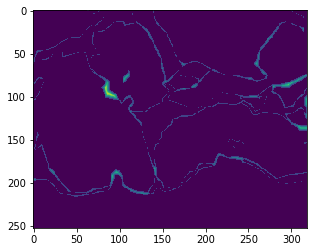

In [23]:
from scipy.ndimage import morphology
dst, inds = morphology.distance_transform_edt(segmentation==0, return_indices=True)
plt.imshow(dst)

# Fill the gaps

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


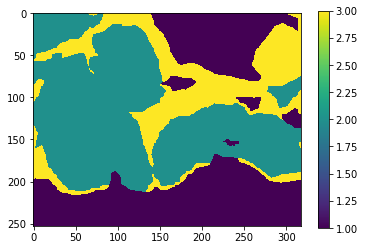

In [24]:
# plt.imshow(segmentation[inds[0], inds[1]])
filled = segmentation[[*inds]]
plt.imshow(filled, vmin=1)
plt.colorbar()

In [25]:
plt.imsave(ofn_filled, filled, 
#            cmap='gray', 
           vmin=0) # , "fn.png")

In [26]:
Path(fn).stem

'PIG-003_J-18-0165_HE'

In [27]:
# ann_raster = view.get_annotation_region_raster(outer_ids[0], holes_ids=hole_ids)

# Whole dataset preparation


Get training labels from whole dataset

In [5]:
output_path_images = Path(io3d.datasets.join_path(
    "medical/processed/scaffan2019/whole_scan_ground_true_training_annotations", get_root=True
))
fns = [
    "medical/orig/Scaffan-analysis/PIG-001_J-17-0571_LM central_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-001_J-17-0569_LM_HE.ndpi",
    # "medical/orig/Scaffan-analysis/PIG-001_J-17-0567_edge RM_HE.ndpi",  # no annotation
    "medical/orig/Scaffan-analysis/PIG-002_J-18-0091_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-002_J-18-0092_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-002_J-18-0094_HE_rescan.ndpi", # bad focus
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0166_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0167_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0168_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0169_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-003_J-18-0170_HE.ndpi",
    "medical/orig/Scaffan-analysis/PIG-004_BBJ-004-4_HE_parenchyme.ndpi",
    "medical/orig/Scaffan-analysis/PIG-004_BBJ-004-3 _HE_parenchyme.ndpi",
    "medical/orig/Scaffan-analysis/PIG-004_BBJ-004-2 _HE_parenchyme.ndpi",
    "medical/orig/Scaffan-analysis/PIG-005_J-18-0630_HE_LLL per decell.ndpi",
    "medical/orig/Scaffan-analysis/PIG-005_J-18-0631_HE_LML per decell.ndpi",
    "medical/orig/Scaffan-analysis/PIG-005_J-18-0633_HE_PRML per decell.ndpi",
    "medical/orig/Scaffan-analysis/PIG-008_P008 LL-C_HE_parenchyme centr..ndpi",
    "medical/orig/Scaffan-analysis/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi",
    #
    # "medical/orig/Scaffan-analysis-hů/PIG-001_J-17-0571_LM central_HE.ndpi", # Test diacritics
    #
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-014_Pilsen_HE_LM-P.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-013_Pilsen_HE_013-LL-P.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pilsen_Pig-015_HE_RLP_7.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pilsen_Pig-015_HE_RMP_4.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-014_Pilsen_HE_RL-C.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-010_Pilsen_HE_RM-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-013_Pilsen_HE_013-LL-C (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-009_Pilsen_HE_009-LM-P.ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-010_Pilsen_HE_LL-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-011_Pilsen_HE_LL-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-009_Pilsen_HE_009-RL-C (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/PIG-012_Pilsen_HE_LLP (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/Pig-011_Pilsen_HE_RM-P (1).ndpi',
    'medical/orig/Scaffan-analysis-whole-scan-addition/PIG-012_Pilsen_HE_LMC (1).ndpi',
]


2020-04-01 21:55:30.557 | DEBUG    | io3d.cachefile:__init__:26 - cache filename: ~/.io3d_cache.yaml
2020-04-01 21:55:30.561 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_.
2020-04-01 21:55:30.564 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_medical
2020-04-01 21:55:30.566 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_medical/orig
2020-04-01 21:55:30.568 | DEBUG    | io3d.datasets:dataset_path:394 - checking for key local_dataset_specific_dir_medical/orig/Scaffan-analysis
2020-04-01 21:55:30.570 | DEBUG    | io3d.datasets:join_path:304 - sample_data_pathC:\Users\Jirik\data
2020-04-01 21:55:30.571 | DEBUG    | io3d.datasets:join_path:305 - path C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0571_LM central_HE.ndpi
2020-04-01 21:55:30.577 | DEBUG    | scaffan.slide_segmentation:__init__:207 - Reading classifier from C:\Users\Jirik\projects\s

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0571_LM central_HE.ndpi exists=True 


2020-04-01 21:55:31.740 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:55:31.620\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:55:31.747 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:55:31.748 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:55:32.183 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:55:32.184 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:55:32.184 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:55:32.185 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 21:55:54.974 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0569_LM_HE.ndpi exists=True 


2020-04-01 21:56:14.563 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:56:14.435\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:56:14.568 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:56:14.568 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:56:15.077 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:56:15.079 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:56:15.080 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:56:15.081 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 21:56:37.745 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0091_HE.ndpi exists=True 


2020-04-01 21:56:47.771 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:56:47.637\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:56:47.775 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:56:47.777 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:56:48.119 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:56:48.121 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:56:48.122 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:56:48.123 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 21:57:04.638 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0092_HE.ndpi exists=True 


2020-04-01 21:57:23.756 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:57:23.621\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:57:23.763 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:57:23.766 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:57:24.239 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:57:24.240 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:57:24.240 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:57:24.241 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 21:57:46.006 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0094_HE_rescan.ndpi exists=True 


2020-04-01 21:58:02.165 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:58:01.995\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:58:02.169 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:58:02.171 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:58:02.277 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:58:02.278 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:58:02.279 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:58:02.279 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 21:58:20.630 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi exists=True 


2020-04-01 21:58:29.220 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:58:29.081\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:58:29.232 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:58:29.233 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:58:29.631 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:58:29.632 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:58:29.633 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:58:29.633 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 21:58:37.693 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0166_HE.ndpi exists=True 


2020-04-01 21:59:25.858 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:59:25.725\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:59:25.863 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:59:25.866 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:59:26.047 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:59:26.048 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:59:26.048 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:59:26.049 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 21:59:42.397 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0167_HE.ndpi exists=True 


2020-04-01 21:59:55.969 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 21:59:55.813\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 21:59:55.974 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 21:59:55.976 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 21:59:56.306 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 21:59:56.307 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 21:59:56.308 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 21:59:56.308 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:00:27.100 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0168_HE.ndpi exists=True 


2020-04-01 22:00:42.892 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:00:42.768\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:00:42.899 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:00:42.900 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:00:43.053 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:00:43.054 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:00:43.055 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:00:43.055 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:00:56.480 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0169_HE.ndpi exists=True 


2020-04-01 22:01:04.058 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:01:03.943\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:01:04.063 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:01:04.064 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:01:04.175 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:01:04.176 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:01:04.177 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:01:04.177 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:01:15.670 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0170_HE.ndpi exists=True 


2020-04-01 22:01:21.032 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:01:20.929\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:01:21.037 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:01:21.038 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:01:21.217 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:01:21.218 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:01:21.219 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:01:21.220 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:01:34.496 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-4_HE_parenchyme.ndpi exists=True 


2020-04-01 22:01:41.890 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:01:41.743\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:01:41.898 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:01:41.900 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:01:42.240 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:01:42.241 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:01:42.242 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:01:42.243 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:02:05.570 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-3 _HE_parenchyme.ndpi exists=True 


2020-04-01 22:02:27.470 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:02:27.344\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:02:27.478 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:02:27.479 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:02:27.629 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:02:27.630 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:02:27.630 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:02:27.631 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:02:38.292 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-2 _HE_parenchyme.ndpi exists=True 


2020-04-01 22:02:45.925 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:02:45.783\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:02:45.934 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:02:45.935 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:02:46.437 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:02:46.438 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:02:46.439 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:02:46.439 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:03:12.236 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0630_HE_LLL per decell.ndpi exists=True 


2020-04-01 22:03:29.176 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:03:29.046\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:03:29.182 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:03:29.184 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:03:29.341 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:03:29.342 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:03:29.343 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:03:29.343 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:03:42.295 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0631_HE_LML per decell.ndpi exists=True 


2020-04-01 22:03:55.881 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:03:55.715\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:03:55.887 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:03:55.889 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:03:56.077 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:03:56.079 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:03:56.080 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:03:56.080 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:04:03.895 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0633_HE_PRML per decell.ndpi exists=True 


2020-04-01 22:04:10.771 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:04:10.442\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:04:10.784 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:04:10.787 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:04:11.334 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:04:11.336 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:04:11.338 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:04:11.339 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:04:27.602 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-008_P008 LL-C_HE_parenchyme centr..ndpi exists=True 


2020-04-01 22:04:44.852 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:04:44.718\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:04:44.857 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:04:44.858 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:04:45.091 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:04:45.092 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:04:45.093 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:04:45.093 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:05:00.731 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-008_P008 LL-P_HE_parenchyme perif..ndpi exists=True 


2020-04-01 22:05:08.300 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:05:08.184\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:05:08.306 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:05:08.307 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:05:08.751 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:05:08.753 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:05:08.753 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:05:08.754 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:05:33.107 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-014_Pilsen_HE_LM-P.ndpi exists=True 


2020-04-01 22:05:38.933 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:05:38.828\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:05:38.937 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:05:38.938 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:05:39.003 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:05:39.004 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:05:39.005 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:05:39.006 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:06:01.559 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-013_Pilsen_HE_013-LL-P.ndpi exists=True 


2020-04-01 22:06:10.801 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:06:10.607\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:06:10.808 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:06:10.812 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:06:10.913 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:06:10.914 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:06:10.915 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:06:10.916 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:06:32.045 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pilsen_Pig-015_HE_RLP_7.ndpi exists=True 


2020-04-01 22:06:40.982 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:06:40.881\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:06:40.986 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:06:40.987 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:06:41.045 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:06:41.046 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:06:41.046 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:06:41.047 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:07:03.361 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pilsen_Pig-015_HE_RMP_4.ndpi exists=True 


2020-04-01 22:07:08.868 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:07:08.764\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:07:08.873 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:07:08.874 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:07:08.917 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:07:08.917 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:07:08.918 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:07:08.919 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:07:26.316 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-014_Pilsen_HE_RL-C.ndpi exists=True 


2020-04-01 22:07:31.177 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:07:31.081\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:07:31.181 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:07:31.183 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:07:31.280 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:07:31.280 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:07:31.281 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:07:31.282 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:08:16.709 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-010_Pilsen_HE_RM-P (1).ndpi exists=True 


2020-04-01 22:08:28.122 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:08:28.019\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:08:28.126 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:08:28.127 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:08:28.168 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:08:28.169 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:08:28.170 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:08:28.170 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:08:45.722 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-013_Pilsen_HE_013-LL-C (1).ndpi exists=True 


2020-04-01 22:08:50.606 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:08:50.506\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:08:50.610 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:08:50.611 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:08:50.689 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:08:50.691 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:08:50.692 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:08:50.693 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:09:26.576 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-009_Pilsen_HE_009-LM-P.ndpi exists=True 


2020-04-01 22:09:41.012 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:09:40.904\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:09:41.016 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:09:41.018 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:09:41.182 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:09:41.183 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:09:41.183 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:09:41.184 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:10:24.019 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-010_Pilsen_HE_LL-P (1).ndpi exists=True 


2020-04-01 22:10:43.651 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:10:43.555\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:10:43.654 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:10:43.656 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:10:43.740 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:10:43.741 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:10:43.741 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:10:43.742 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:11:02.422 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-011_Pilsen_HE_LL-P (1).ndpi exists=True 


2020-04-01 22:11:11.506 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:11:11.420\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:11:11.509 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:11:11.510 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:11:11.564 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:11:11.565 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:11:11.566 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:11:11.566 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:11:34.807 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-009_Pilsen_HE_009-RL-C (1).ndpi exists=True 


2020-04-01 22:11:41.091 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:11:40.993\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:11:41.094 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:11:41.096 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:11:41.281 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:11:41.282 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:11:41.282 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:11:41.283 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:12:21.395 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\PIG-012_Pilsen_HE_LLP (1).ndpi exists=True 


2020-04-01 22:12:42.277 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:12:42.179\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:12:42.281 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:12:42.282 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:12:42.325 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:12:42.326 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:12:42.327 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:12:42.328 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:13:01.035 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-011_Pilsen_HE_RM-P (1).ndpi exists=True 


2020-04-01 22:13:06.116 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:13:06.016\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:13:06.121 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:13:06.122 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:13:06.235 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:13:06.236 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:13:06.237 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:13:06.238 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:13:41.338 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\PIG-012_Pilsen_HE_LMC (1).ndpi exists=True 


2020-04-01 22:13:51.643 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:13:51.549\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:13:51.647 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:13:51.648 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:13:51.724 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:13:51.725 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:13:51.725 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:13:51.726 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:14:07.652 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0571_LM central_HE.ndpi exists=True 


2020-04-01 22:14:11.901 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:14:11.802\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:14:11.906 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:14:11.907 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:14:12.307 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:14:12.308 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:14:12.308 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:14:12.309 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:14:31.450 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0569_LM_HE.ndpi exists=True 


2020-04-01 22:14:46.275 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:14:46.174\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:14:46.280 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:14:46.281 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:14:46.618 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:14:46.618 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:14:46.619 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:14:46.619 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:15:05.345 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0091_HE.ndpi exists=True 


2020-04-01 22:15:12.954 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:15:12.845\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:15:12.958 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:15:12.960 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:15:13.630 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:15:13.631 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:15:13.631 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:15:13.632 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:15:27.102 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0092_HE.ndpi exists=True 


2020-04-01 22:15:42.673 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:15:42.555\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:15:42.677 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:15:42.678 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:15:43.065 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:15:43.066 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:15:43.067 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:15:43.067 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:15:58.219 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0094_HE_rescan.ndpi exists=True 


2020-04-01 22:16:10.383 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:16:10.292\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:16:10.387 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:16:10.388 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:16:10.451 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:16:10.452 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:16:10.453 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:16:10.453 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:16:23.658 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi exists=True 


2020-04-01 22:16:30.987 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:16:30.867\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:16:30.993 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:16:30.995 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:16:31.362 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:16:31.363 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:16:31.363 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:16:31.364 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:16:38.914 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0166_HE.ndpi exists=True 


2020-04-01 22:17:10.690 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:17:10.579\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:17:10.697 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:17:10.698 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:17:10.877 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:17:10.878 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:17:10.878 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:17:10.879 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:17:20.802 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0167_HE.ndpi exists=True 


2020-04-01 22:17:28.165 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:17:28.063\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:17:28.169 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:17:28.170 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:17:28.422 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:17:28.423 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:17:28.424 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:17:28.424 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:17:43.693 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0168_HE.ndpi exists=True 


2020-04-01 22:17:54.770 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:17:54.656\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:17:54.775 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:17:54.777 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:17:54.979 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:17:54.981 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:17:54.981 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:17:54.982 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:18:10.333 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0169_HE.ndpi exists=True 


2020-04-01 22:18:17.179 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:18:17.074\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:18:17.183 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:18:17.184 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:18:17.283 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:18:17.284 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:18:17.285 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:18:17.286 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:18:26.838 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0170_HE.ndpi exists=True 


2020-04-01 22:18:32.447 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:18:32.339\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:18:32.452 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:18:32.454 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:18:32.627 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:18:32.628 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:18:32.629 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:18:32.630 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:18:45.816 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-4_HE_parenchyme.ndpi exists=True 


2020-04-01 22:18:52.316 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:18:52.208\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:18:52.321 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:18:52.322 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:18:52.586 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:18:52.587 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:18:52.588 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:18:52.588 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:19:08.219 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-3 _HE_parenchyme.ndpi exists=True 


2020-04-01 22:19:24.586 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:19:24.483\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:19:24.589 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:19:24.591 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:19:24.711 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:19:24.712 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:19:24.713 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:19:24.714 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:19:33.223 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-2 _HE_parenchyme.ndpi exists=True 


2020-04-01 22:19:39.071 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:19:38.969\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:19:39.076 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:19:39.077 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:19:39.434 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:19:39.435 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:19:39.435 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:19:39.436 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:19:59.159 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0630_HE_LLL per decell.ndpi exists=True 


2020-04-01 22:20:10.732 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:20:10.627\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:20:10.736 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:20:10.738 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:20:10.860 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:20:10.861 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:20:10.861 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:20:10.862 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:20:18.481 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0631_HE_LML per decell.ndpi exists=True 


2020-04-01 22:20:24.869 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:20:24.724\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:20:24.877 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:20:24.878 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:20:25.045 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:20:25.047 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:20:25.048 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:20:25.049 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:20:30.088 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0633_HE_PRML per decell.ndpi exists=True 


2020-04-01 22:20:34.055 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:20:33.948\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:20:34.059 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:20:34.060 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:20:34.270 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:20:34.271 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:20:34.271 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:20:34.272 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:20:45.371 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-008_P008 LL-C_HE_parenchyme centr..ndpi exists=True 


2020-04-01 22:20:54.057 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:20:53.957\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:20:54.060 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:20:54.061 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:20:54.218 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:20:54.219 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:20:54.219 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:20:54.220 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:21:06.019 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-008_P008 LL-P_HE_parenchyme perif..ndpi exists=True 


2020-04-01 22:21:11.468 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:21:11.360\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:21:11.473 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:21:11.474 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:21:11.946 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:21:11.947 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:21:11.948 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:21:11.948 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:21:29.525 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-014_Pilsen_HE_LM-P.ndpi exists=True 


2020-04-01 22:21:34.844 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:21:34.737\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:21:34.848 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:21:34.849 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:21:34.905 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:21:34.906 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:21:34.907 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:21:34.908 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:21:56.030 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-013_Pilsen_HE_013-LL-P.ndpi exists=True 


2020-04-01 22:22:01.811 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:22:01.707\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:22:01.814 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:22:01.815 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:22:01.877 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:22:01.877 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:22:01.878 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:22:01.879 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:22:18.715 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pilsen_Pig-015_HE_RLP_7.ndpi exists=True 


2020-04-01 22:22:24.223 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:22:24.128\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:22:24.226 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:22:24.226 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:22:24.272 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:22:24.273 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:22:24.274 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:22:24.274 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:22:41.982 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pilsen_Pig-015_HE_RMP_4.ndpi exists=True 


2020-04-01 22:22:47.319 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:22:47.230\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:22:47.322 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:22:47.323 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:22:47.362 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:22:47.363 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:22:47.363 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:22:47.363 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:23:02.331 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-014_Pilsen_HE_RL-C.ndpi exists=True 


2020-04-01 22:23:06.957 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:23:06.859\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:23:06.960 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:23:06.961 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:23:07.057 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:23:07.058 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:23:07.058 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:23:07.059 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:23:36.712 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-010_Pilsen_HE_RM-P (1).ndpi exists=True 


2020-04-01 22:23:45.344 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:23:45.251\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:23:45.346 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:23:45.347 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:23:45.382 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:23:45.383 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:23:45.383 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:23:45.384 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:23:58.660 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-013_Pilsen_HE_013-LL-C (1).ndpi exists=True 


2020-04-01 22:24:02.611 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:24:02.514\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:24:02.615 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:24:02.616 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:24:02.694 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:24:02.695 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:24:02.696 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:24:02.696 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:24:27.247 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-009_Pilsen_HE_009-LM-P.ndpi exists=True 


2020-04-01 22:24:34.413 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:24:34.315\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:24:34.416 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:24:34.418 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:24:34.557 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:24:34.558 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:24:34.559 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:24:34.560 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:25:06.518 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-010_Pilsen_HE_LL-P (1).ndpi exists=True 


2020-04-01 22:25:23.679 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:25:23.586\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:25:23.683 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:25:23.684 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:25:23.809 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:25:23.810 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:25:23.811 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:25:23.811 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:25:40.104 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-011_Pilsen_HE_LL-P (1).ndpi exists=True 


2020-04-01 22:25:46.936 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:25:46.845\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:25:46.939 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:25:46.940 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:25:46.996 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:25:46.997 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:25:46.997 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:25:46.998 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:26:11.884 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-009_Pilsen_HE_009-RL-C (1).ndpi exists=True 


2020-04-01 22:26:17.868 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:26:17.764\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:26:17.872 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:26:17.873 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:26:18.047 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:26:18.048 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:26:18.049 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:26:18.049 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:26:57.243 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\PIG-012_Pilsen_HE_LLP (1).ndpi exists=True 


2020-04-01 22:27:16.806 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:27:16.702\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:27:16.809 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:27:16.810 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:27:16.861 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:27:16.862 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:27:16.862 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:27:16.863 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:27:34.310 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-011_Pilsen_HE_RM-P (1).ndpi exists=True 


2020-04-01 22:27:38.814 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:27:38.713\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:27:38.817 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:27:38.819 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:27:38.918 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:27:38.919 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:27:38.920 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:27:38.920 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:28:12.190 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\PIG-012_Pilsen_HE_LMC (1).ndpi exists=True 


2020-04-01 22:28:21.105 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:28:21.012\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:28:21.108 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:28:21.109 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:28:21.158 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:28:21.158 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:28:21.159 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:28:21.159 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:28:37.368 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0571_LM central_HE.ndpi exists=True 


2020-04-01 22:28:41.953 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:28:41.846\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:28:41.958 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:28:41.959 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:28:42.366 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:28:42.367 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:28:42.367 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:28:42.368 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:29:01.514 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-001_J-17-0569_LM_HE.ndpi exists=True 


2020-04-01 22:29:16.257 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:29:16.159\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:29:16.261 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:29:16.262 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:29:16.582 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:29:16.583 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:29:16.583 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:29:16.584 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:29:35.033 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0091_HE.ndpi exists=True 


2020-04-01 22:29:42.626 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:29:42.517\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:29:42.630 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:29:42.631 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:29:42.892 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:29:42.893 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:29:42.894 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:29:42.894 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:29:55.767 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0092_HE.ndpi exists=True 


2020-04-01 22:30:11.134 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:30:11.024\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:30:11.139 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:30:11.140 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:30:11.484 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:30:11.485 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:30:11.485 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:30:11.486 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:30:25.487 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-002_J-18-0094_HE_rescan.ndpi exists=True 


2020-04-01 22:30:35.620 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:30:35.525\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:30:35.624 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:30:35.625 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:30:35.690 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:30:35.691 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:30:35.692 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:30:35.692 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:30:48.010 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi exists=True 


2020-04-01 22:30:54.708 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:30:54.570\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:30:54.714 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:30:54.716 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:30:55.214 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:30:55.216 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:30:55.216 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:30:55.217 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:31:02.690 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0166_HE.ndpi exists=True 


2020-04-01 22:31:34.261 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:31:34.162\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:31:34.266 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:31:34.267 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:31:34.392 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:31:34.393 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:31:34.393 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:31:34.393 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:31:44.428 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0167_HE.ndpi exists=True 


2020-04-01 22:31:51.726 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:31:51.625\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:31:51.729 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:31:51.731 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:31:52.018 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:31:52.019 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:31:52.019 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:31:52.020 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:32:07.012 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0168_HE.ndpi exists=True 


2020-04-01 22:32:17.276 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:32:17.179\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:32:17.279 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:32:17.281 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:32:17.423 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:32:17.424 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:32:17.424 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:32:17.425 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:32:30.279 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0169_HE.ndpi exists=True 


2020-04-01 22:32:37.081 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:32:36.977\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:32:37.085 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:32:37.086 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:32:37.192 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:32:37.193 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:32:37.193 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:32:37.194 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:32:46.378 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0170_HE.ndpi exists=True 


2020-04-01 22:32:51.279 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:32:51.177\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:32:51.282 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:32:51.284 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:32:51.512 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:32:51.513 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:32:51.513 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:32:51.514 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:33:03.600 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-4_HE_parenchyme.ndpi exists=True 


2020-04-01 22:33:09.212 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:33:09.110\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:33:09.216 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:33:09.217 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:33:09.744 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:33:09.745 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:33:09.745 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:33:09.746 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:33:23.714 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-3 _HE_parenchyme.ndpi exists=True 


2020-04-01 22:33:39.462 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:33:39.363\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:33:39.467 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:33:39.468 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:33:39.582 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:33:39.583 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:33:39.584 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:33:39.584 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:33:47.847 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-004_BBJ-004-2 _HE_parenchyme.ndpi exists=True 


2020-04-01 22:33:53.630 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:33:53.529\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:33:53.635 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:33:53.636 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:33:54.009 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:33:54.010 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:33:54.011 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:33:54.011 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:34:15.541 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0630_HE_LLL per decell.ndpi exists=True 


2020-04-01 22:34:27.527 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:34:27.424\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:34:27.532 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:34:27.533 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:34:27.652 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:34:27.653 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:34:27.653 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:34:27.654 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:34:35.729 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0631_HE_LML per decell.ndpi exists=True 


2020-04-01 22:34:42.430 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:34:42.329\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:34:42.435 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:34:42.436 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:34:42.520 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:34:42.521 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:34:42.521 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:34:42.522 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:34:47.869 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-005_J-18-0633_HE_PRML per decell.ndpi exists=True 


2020-04-01 22:34:52.238 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:34:52.125\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:34:52.243 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:34:52.244 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:34:52.591 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:34:52.592 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:34:52.592 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:34:52.593 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:35:03.507 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-008_P008 LL-C_HE_parenchyme centr..ndpi exists=True 


2020-04-01 22:35:12.952 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:35:12.841\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:35:12.956 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:35:12.957 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:35:13.116 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:35:13.117 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:35:13.118 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:35:13.118 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:35:25.435 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis\PIG-008_P008 LL-P_HE_parenchyme perif..ndpi exists=True 


2020-04-01 22:35:30.878 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:35:30.756\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:35:30.882 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:35:30.883 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.0072719 0.0072805]
2020-04-01 22:35:31.327 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:35:31.328 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:35:31.328 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:35:31.329 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:35:48.260 | DEBUG    | scaffan.slide_segmentation:predict:514 - co

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-014_Pilsen_HE_LM-P.ndpi exists=True 


2020-04-01 22:35:53.140 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:35:53.049\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:35:53.142 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:35:53.144 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:35:53.195 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:35:53.195 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:35:53.196 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:35:53.196 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:36:12.812 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-013_Pilsen_HE_013-LL-P.ndpi exists=True 


2020-04-01 22:36:18.050 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:36:17.956\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:36:18.052 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:36:18.053 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:36:18.109 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:36:18.110 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:36:18.110 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:36:18.111 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:36:33.886 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pilsen_Pig-015_HE_RLP_7.ndpi exists=True 


2020-04-01 22:36:39.263 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:36:39.174\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:36:39.265 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:36:39.266 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:36:39.310 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:36:39.310 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:36:39.311 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:36:39.312 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:36:57.380 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pilsen_Pig-015_HE_RMP_4.ndpi exists=True 


2020-04-01 22:37:02.846 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:37:02.742\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:37:02.850 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:37:02.850 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:37:02.919 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:37:02.920 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:37:02.921 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:37:02.921 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:37:18.989 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-014_Pilsen_HE_RL-C.ndpi exists=True 


2020-04-01 22:37:23.882 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:37:23.779\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:37:23.885 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:37:23.886 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:37:23.983 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:37:23.984 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:37:23.985 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:37:23.985 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:37:55.962 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-010_Pilsen_HE_RM-P (1).ndpi exists=True 


2020-04-01 22:38:04.597 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:38:04.506\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:38:04.601 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:38:04.602 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:38:04.646 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:38:04.647 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:38:04.647 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:38:04.648 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:38:17.012 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-013_Pilsen_HE_013-LL-C (1).ndpi exists=True 


2020-04-01 22:38:20.702 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:38:20.612\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:38:20.705 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:38:20.706 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:38:20.772 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:38:20.773 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:38:20.774 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:38:20.774 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:38:42.918 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-009_Pilsen_HE_009-LM-P.ndpi exists=True 


2020-04-01 22:38:49.245 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:38:49.154\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:38:49.248 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:38:49.248 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:38:49.369 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:38:49.370 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:38:49.371 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:38:49.371 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:39:20.099 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-010_Pilsen_HE_LL-P (1).ndpi exists=True 


2020-04-01 22:39:38.918 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:39:38.823\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:39:38.924 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:39:38.927 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:39:39.014 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:39:39.015 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:39:39.015 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:39:39.016 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:39:56.764 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-011_Pilsen_HE_LL-P (1).ndpi exists=True 


2020-04-01 22:40:04.302 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:40:04.207\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:40:04.305 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:40:04.306 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:40:04.368 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:40:04.369 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:40:04.370 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:40:04.370 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:40:29.151 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-009_Pilsen_HE_009-RL-C (1).ndpi exists=True 


2020-04-01 22:40:35.374 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:40:35.275\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:40:35.376 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:40:35.377 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:40:35.544 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:40:35.545 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:40:35.545 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:40:35.546 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:41:13.490 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\PIG-012_Pilsen_HE_LLP (1).ndpi exists=True 


2020-04-01 22:41:31.271 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:41:31.182\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:41:31.274 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:41:31.275 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:41:31.313 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:41:31.314 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:41:31.314 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:41:31.315 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:41:47.115 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\Pig-011_Pilsen_HE_RM-P (1).ndpi exists=True 


2020-04-01 22:41:51.757 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:41:51.670\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:41:51.760 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:41:51.761 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:41:51.875 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:41:51.876 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:41:51.877 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:41:51.878 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:42:25.221 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

C:\Users\Jirik\data\medical\orig\Scaffan-analysis-whole-scan-addition\PIG-012_Pilsen_HE_LMC (1).ndpi exists=True 


2020-04-01 22:42:34.437 | DEBUG    | scaffan.annotation:read_annotations:122 - windows annotation output:b'\x1b2020-04-01 22:42:34.346\x1b | \x1b\x1bDEBUG   \x1b | \x1bscaffan.annotation\x1b:\x1bndpa_to_json\x1b:\x1b72\x1b - \x1b\x1bPATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\x1b\r\n'
2020-04-01 22:42:34.440 | DEBUG    | scaffan.slide_segmentation:_find_best_level:351 - wanted pixelsize mm=[0.01 0.01]
2020-04-01 22:42:34.441 | DEBUG    | scaffan.slide_segmentation:_find_best_level:367 - real pixelsize mm=[0.00727273 0.00728166]
2020-04-01 22:42:34.486 | DEBUG    | scaffan.slide_segmentation:run:737 - run...
2020-04-01 22:42:34.487 | DEBUG    | scaffan.slide_segmentation:run:755 - predict...
2020-04-01 22:42:34.487 | DEBUG    | scaffan.slide_segmentation:predict:494 - predict
2020-04-01 22:42:34.488 | DEBUG    | scaffan.slide_segmentation:predict_tiles:480 - predicting tiles
2020-04-01 22:42:49.941 | DEBUG    | scaffan.slide_segmentation:predict:514 - 

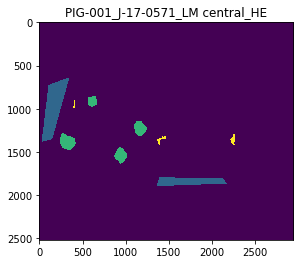

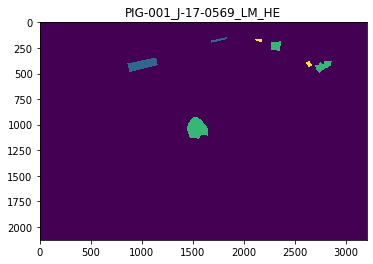

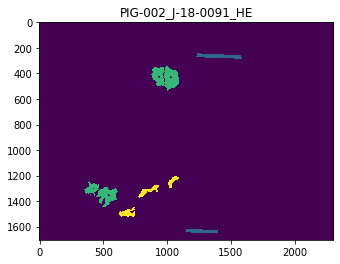

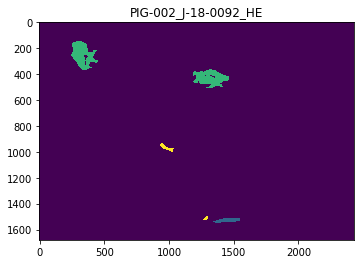

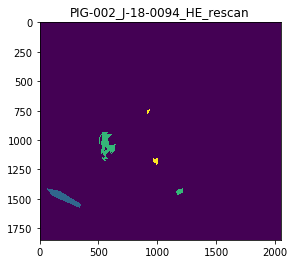

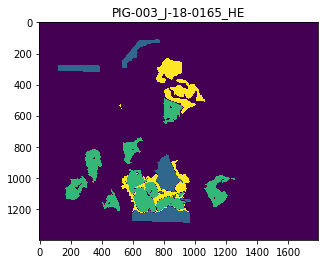

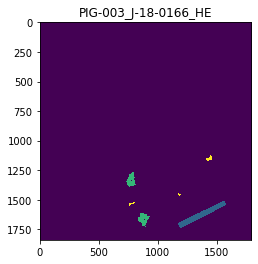

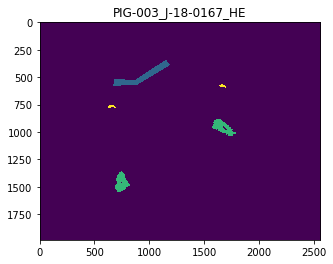

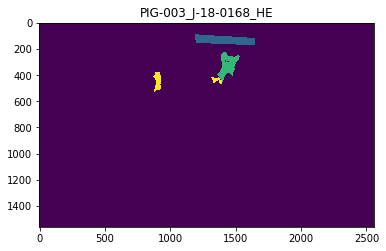

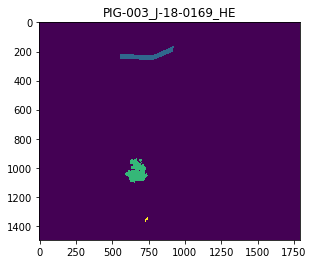

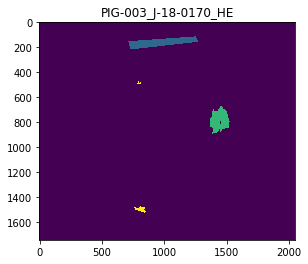

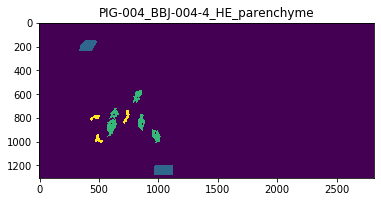

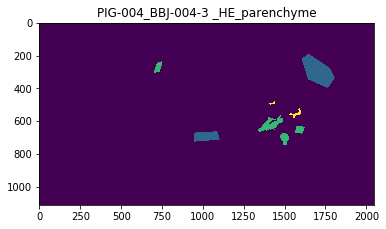

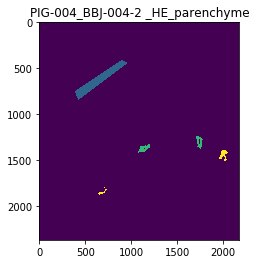

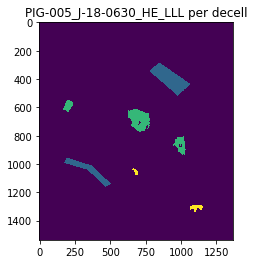

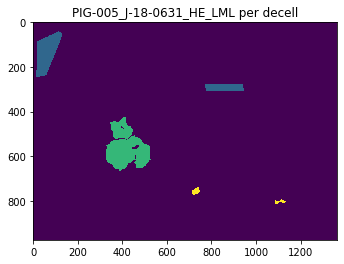

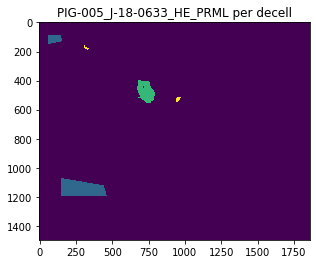

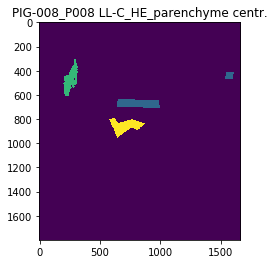

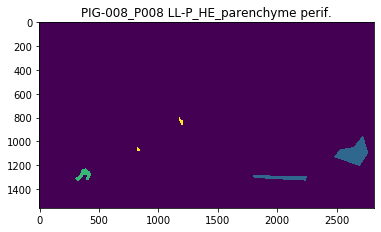

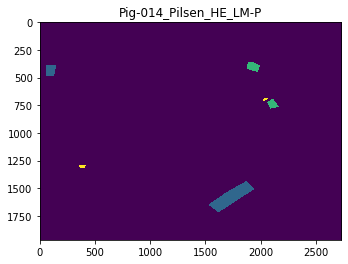

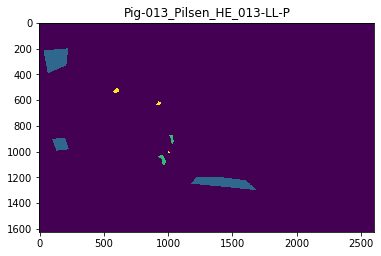

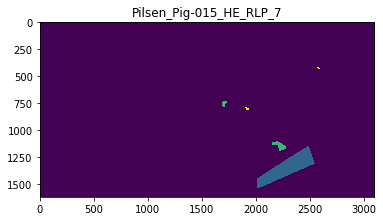

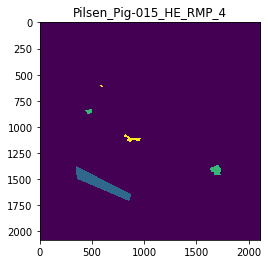

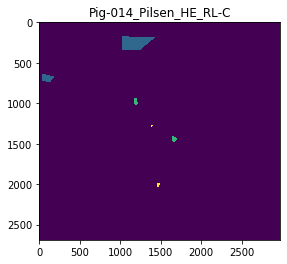

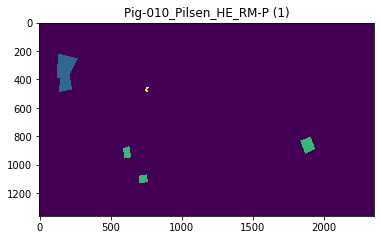

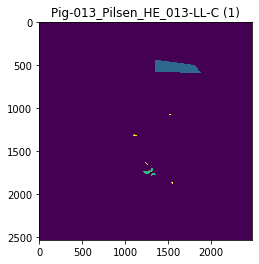

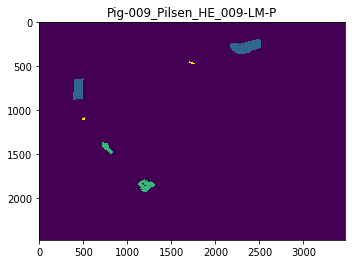

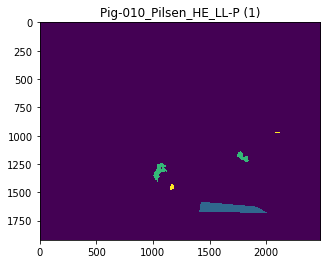

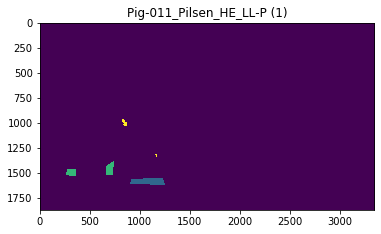

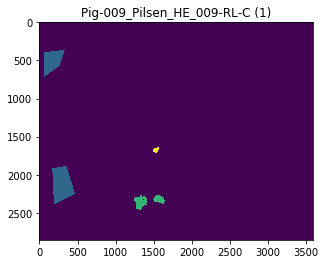

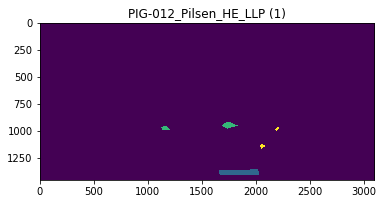

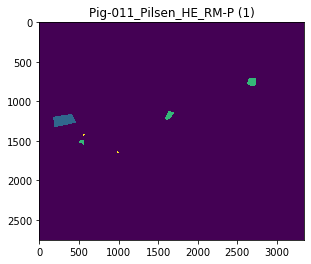

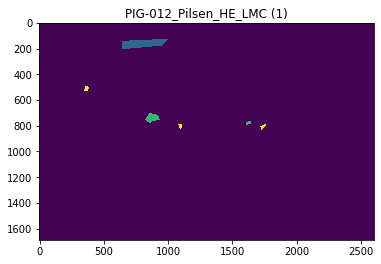

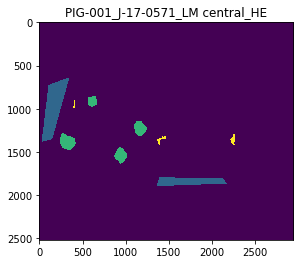

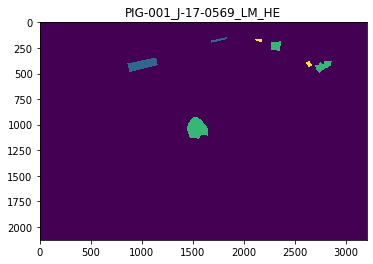

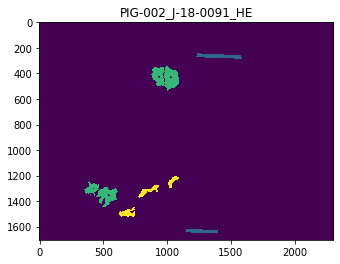

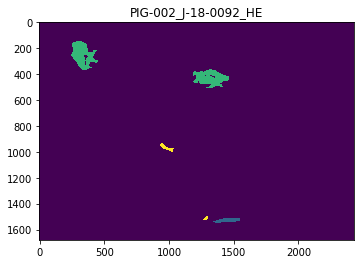

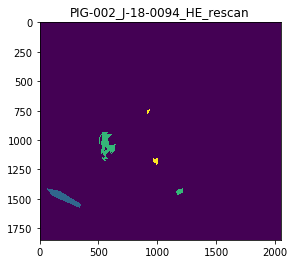

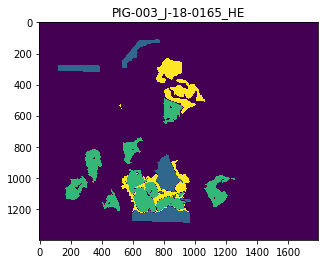

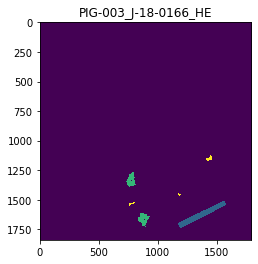

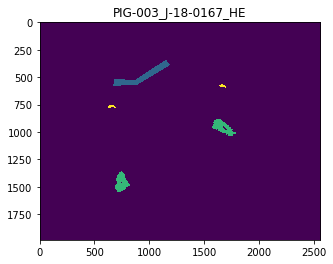

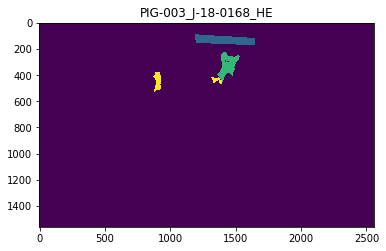

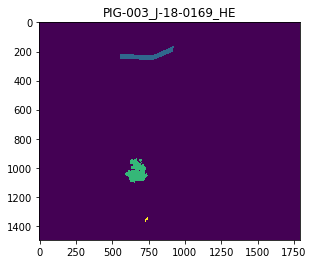

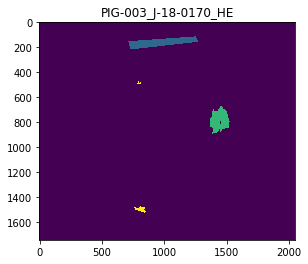

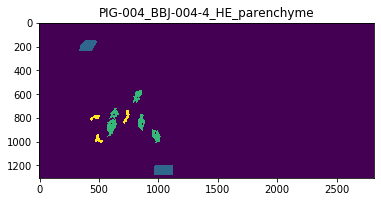

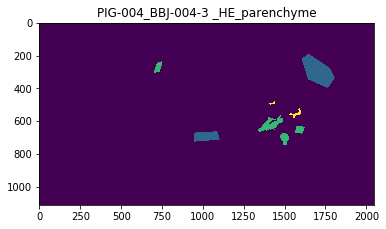

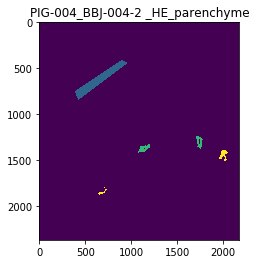

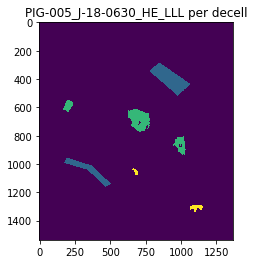

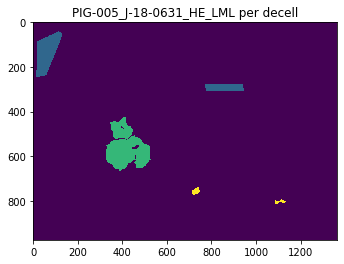

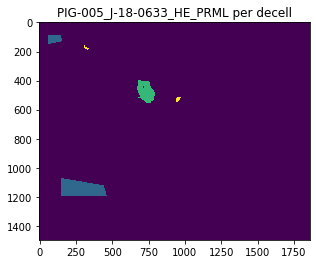

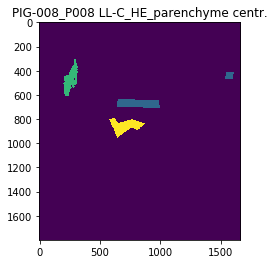

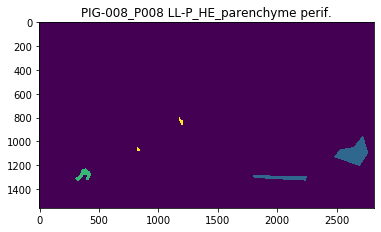

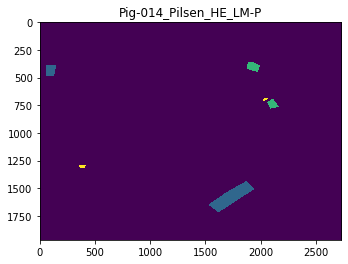

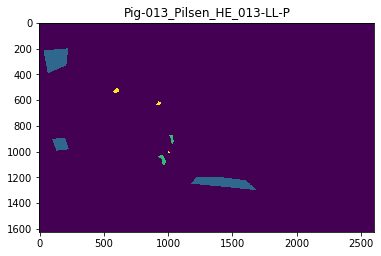

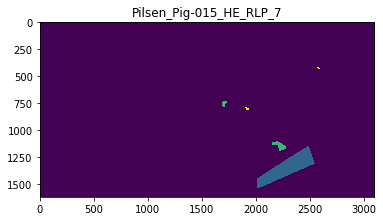

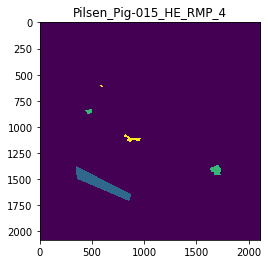

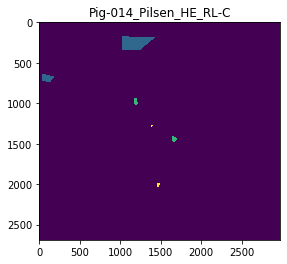

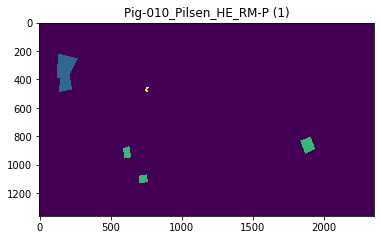

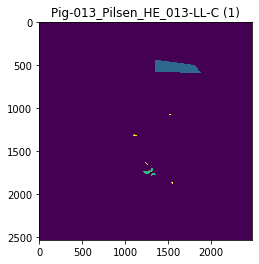

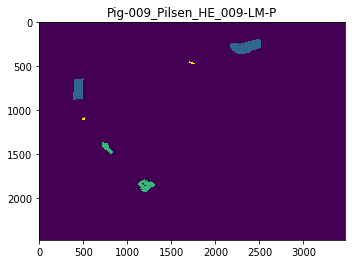

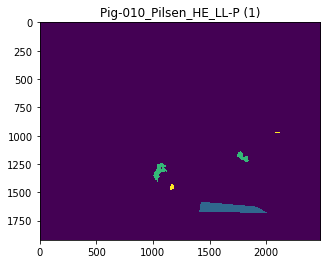

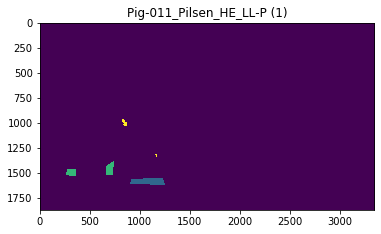

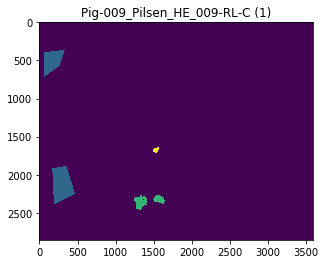

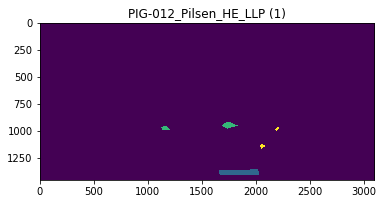

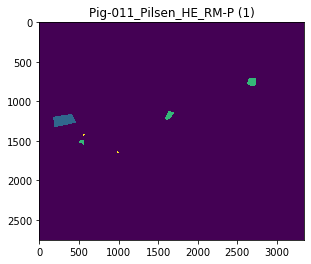

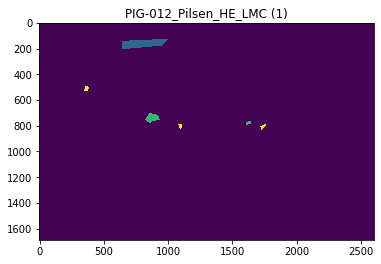

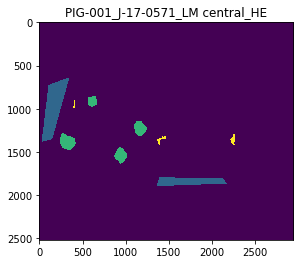

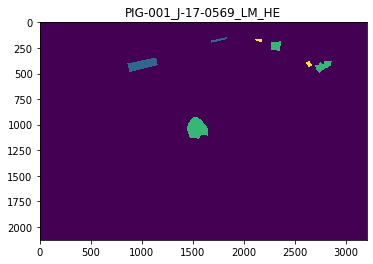

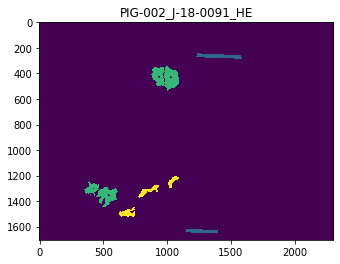

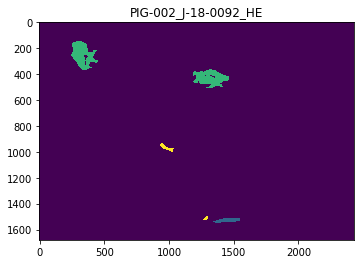

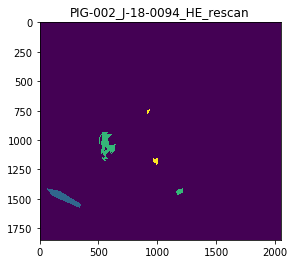

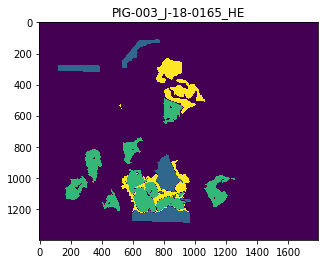

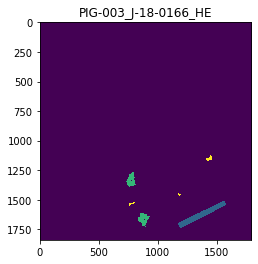

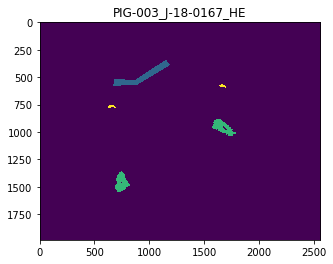

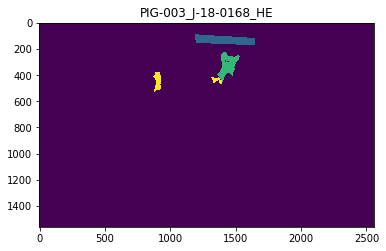

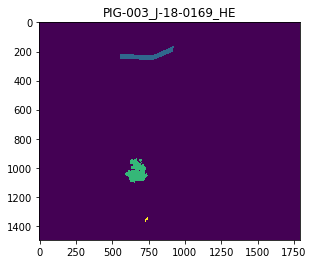

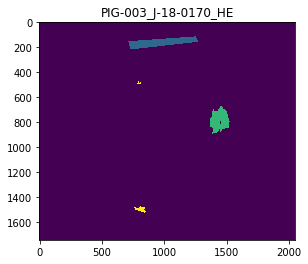

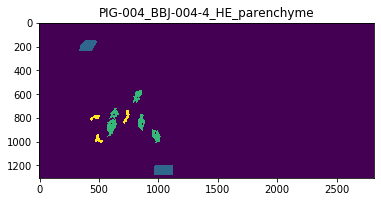

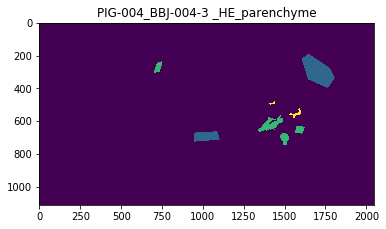

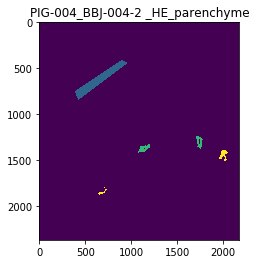

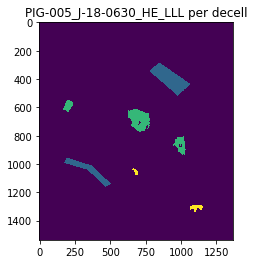

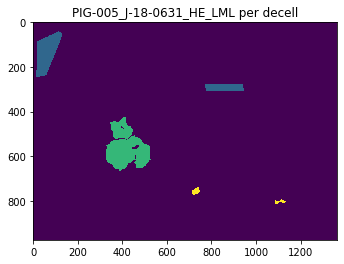

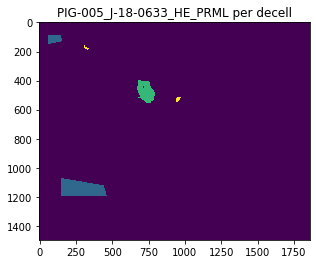

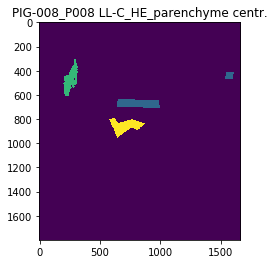

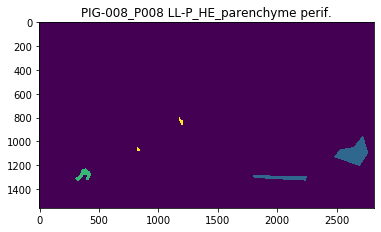

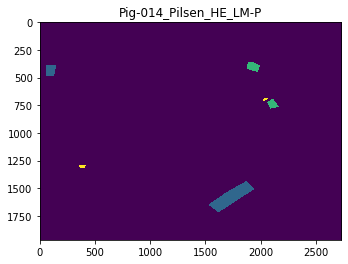

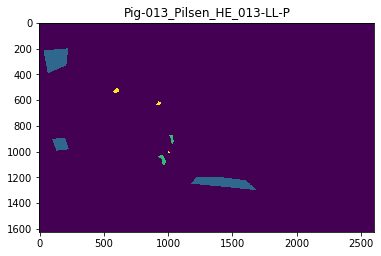

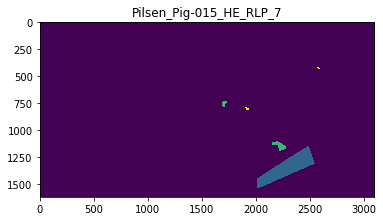

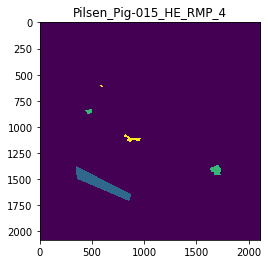

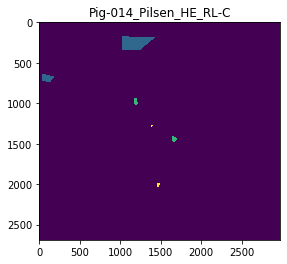

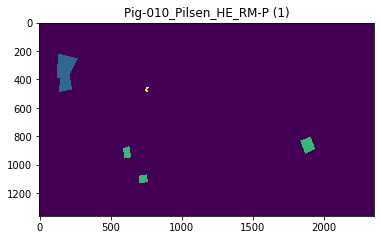

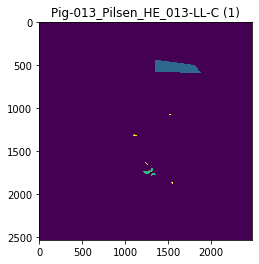

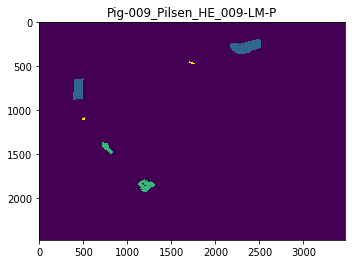

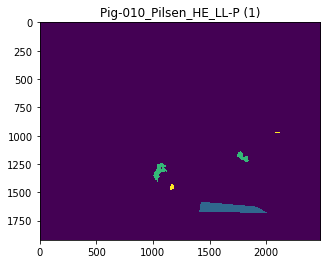

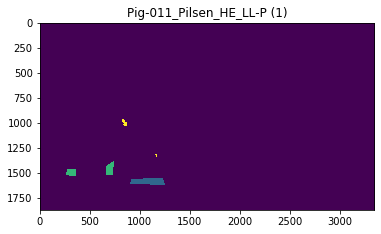

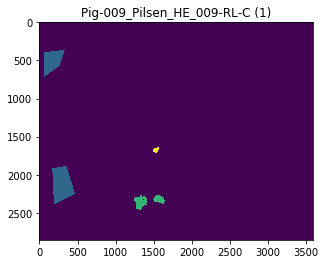

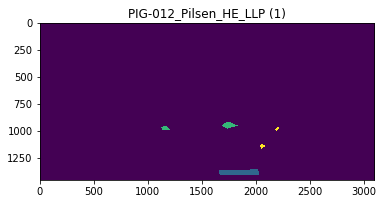

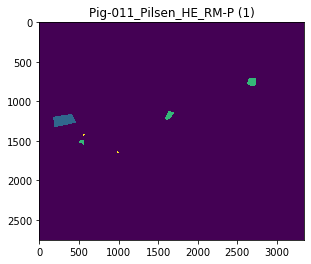

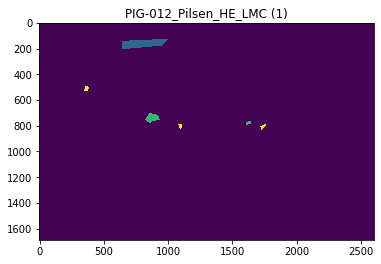

In [14]:

#     fn = io3d.datasets.join_path(
#         "medical", "orig", "sample_data", "SCP003", "SCP003.ndpi", get_root=True
#     )
pixelsizes = [ 0.007271901, 0.00363595, 0.001817975]

# if not os.path.exists(filename):
os.makedirs(output_path_images, exist_ok=True)

for pixelsize0 in pixelsizes:
    pixelsize_mm = [pixelsize0, pixelsize0]
    for fn_in_datasets in fns: 
        fn = io3d.datasets.join_path(fn_in_datasets, get_root=True)
        print(f"{fn} exists={Path(fn).exists()} ")
        
        ofn_gt = output_path_images / f"training_annotation_{Path(fn).stem}_pixelsize_mm_{pixelsize_mm[0]}.png"
        ofn_raster = output_path_images / f"raster_{Path(fn).stem}_pixelsize_mm_{pixelsize_mm[0]}.png"
#         print(fn = Path(fn).stem)
    #     report = exsu.Report(outputdir="./experiment_whole_slide_ground_true/slide_seg_test_output/")
        report = None
        seg = scaffan.slide_segmentation.ScanSegmentation(report=report)
        # dir(seg)
        anim = scaffan.image.AnnotatedImage(fn)

        seg.init(anim)
        seg.parameters.param("Segmentation Method").setValue("U-Net")
        seg.parameters.param("Save Training Labels").setValue(True)
    #     ann_ids_black = seg.anim.select_annotations_by_color("#000000")
    #     assert 10 in ann_ids_black
    #     assert 11 in ann_ids_black
        seg.run()
    #     assert type(seg.full_output_image) == np.ndarray
    #     assert type(seg.full_raster_image) == np.ndarray
    #     assert type(seg.whole_slide_training_labels) == np.ndarray
    #     assert seg.full_raster_image.shape[:2] == seg.full_output_image.shape[:2]
    #     assert seg.whole_slide_training_labels.shape[:2] == seg.full_output_image.shape[:2]
        plt.imsave(ofn_gt, seg.whole_slide_training_labels)
        plt.imsave(ofn_raster, seg.full_raster_image.astype(np.uint8))
        plt.figure()
        plt.title(str(Path(fn).stem))
        plt.imshow(seg.whole_slide_training_labels)